In [5]:
'''
Download one year of daily price data for all S&P 500 stocks
Perform PCA on log returns
Construct two portfolios using the 1st principal component
Compare equity curves with S&P 500 index
'''
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# start and end date for PCA
start_date = pd.to_datetime("2024-01-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2025-10-31", format="%Y-%m-%d")

In [7]:
def get_sp500_tickers():
    """Get the tickers for the S&P 500 from Wikipedia with User-Agent headers."""
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/118.0.0.0 Safari/537.36"
        )
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    table = pd.read_html(response.text)[0]
    tickers = table["Symbol"].str.replace(".", "-", regex=False).tolist()
    return tickers

def get_sp500_price_data(start_date: str, end_date: str):
    """
    Downloads daily historical price data for all S&P 500 tickers.
    
    Parameters:
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        
    Returns:
        pd.DataFrame: Multi-index DataFrame with price data.
    """
    tickers = get_sp500_tickers()
    print(f"Fetching data for {len(tickers)} tickers...")

    data = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        group_by='ticker',
        auto_adjust=True,
        threads=True,
        progress=True
    )

    # extract Close prices
    if isinstance(data.columns, pd.MultiIndex):
        adj_close = data.loc[:, pd.IndexSlice[:, 'Close']]
        adj_close.columns = adj_close.columns.droplevel(1)
    else:
        adj_close = data[['Close']]

    return adj_close

In [8]:
df = get_sp500_price_data(start_date, end_date)

Fetching data for 503 tickers...


[*********************100%***********************]  503 of 503 completed


In [9]:
# get daily log returns of each stock
log_returns = np.log(df / df.shift(1)).fillna(0)

# standardize the values to a mean of zero
# and an std of 1
scaler = StandardScaler()
log_returns_std = pd.DataFrame(
    scaler.fit_transform(log_returns),
    index=log_returns.index,
    columns=log_returns.columns
)


In [10]:
# compute the correlation matrix
corr_matrix = log_returns_std.corr()

In [11]:
# variance, weights
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

## Portfolio 1

In [12]:
# determine the first principles component of the
# eiganvector
max_index = np.argmax(eigenvalues)
principal_eigenvector = eigenvectors[:, max_index]

# normalize the sum to one for weights
weights = principal_eigenvector / np.sum(principal_eigenvector)

# create a dataFrame with ticker and weight
portfolio = pd.DataFrame({
    'Ticker': corr_matrix.columns,
    'Weight': weights
})

In [13]:
# portfolio daily log returns
portfolio_returns = log_returns.dot(weights)

In [14]:
# convert log returns to simple returns
simple_returns = np.exp(portfolio_returns) - 1

# calculate cumulative returns
equity_curve = (1 + simple_returns).cumprod()

In [15]:
sp500 = yf.download("^GSPC", start=log_returns.index.min(), end=log_returns.index.max())
sp500_close = sp500['Close']

# calculate S&P500 daily simple returns
sp500_returns = sp500_close.pct_change().dropna()

# calculate S&P500 cumulative returns
sp500_equity_curve = (1 + sp500_returns).cumprod()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


/Users/alexanderrailton/opt/anaconda3/envs/Alex/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


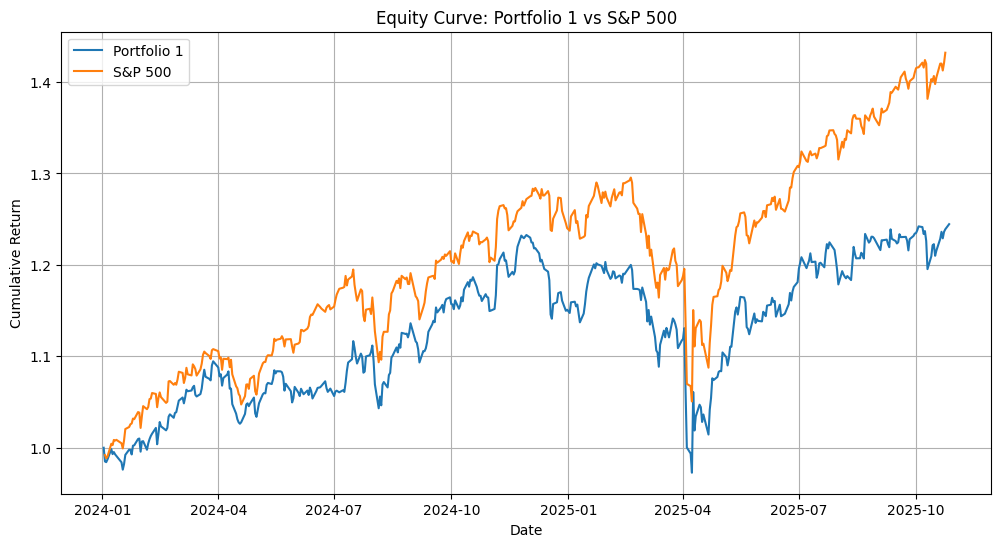

In [16]:
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve, label='Portfolio 1')
plt.plot(sp500_equity_curve.index, sp500_equity_curve, label='S&P 500')
plt.title('Equity Curve: Portfolio 1 vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## Portfolio 2

In [17]:

# volatility
volatility = log_returns.std()

# compute the weights usinf the principle eiganvector
# and the volatility
raw_weights = principal_eigenvector / volatility.values

# normalize weights so they sum to 1
weights_2 = raw_weights / np.sum(np.abs(raw_weights))  # Use absolute sum to keep scale consistent

portfolio_vol_adj = pd.DataFrame({
    'Ticker': log_returns.columns,
    'Weight': weights
})


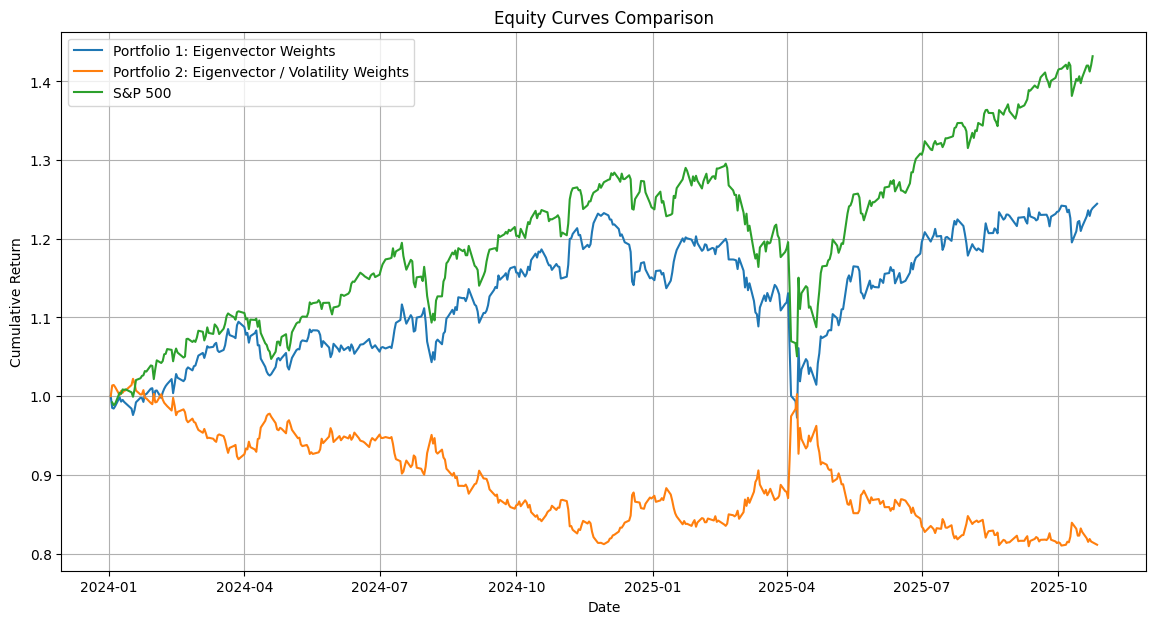

In [18]:
# calculate portfolio returns
portfolio_returns_2 = log_returns.dot(weights_2)

simple_returns_2 = np.exp(portfolio_returns_2) - 1

# calculate cumulative returns (equity curves)
equity_curve_2 = (1 + simple_returns_2).cumprod()

#  plot all values for analysis
plt.figure(figsize=(14,7))
plt.plot(equity_curve.index, equity_curve, label='Portfolio 1: Eigenvector Weights')
plt.plot(equity_curve_2.index, equity_curve_2, label='Portfolio 2: Eigenvector / Volatility Weights')
plt.plot(sp500_equity_curve.index, sp500_equity_curve, label='S&P 500')

plt.title('Equity Curves Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()